# Cats and dogs with pretrained convnet (I - no data augmentation)

In [20]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16

from keras import models
from keras import layers
from keras import optimizers

import matplotlib.pyplot as plt

### Define folders

In [2]:
base_dir = './cats_and_dogs_small/'

In [12]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Load pretrained convnet

In [3]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

/datalinux/giudice/software/anaconda/anaconda3/envs/deeplearning_theano/lib/python3.7/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Extract features

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
# validation_features, validation_labels = extract_features(validation_dir, 1000)
# test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


In [9]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


In [10]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


### The extracted features are currently of shape (samples, 4, 4, 512); we feed them to a densely connected classifier, so we flatten them to (samples, 8192)

In [13]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Define your densely connected classifier

In [15]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))

#for regularisation
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [18]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 18s 9ms/step - loss: 0.6200 - acc: 0.6610 - val_loss: 0.4438 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 17s 8ms/step - loss: 0.4328 - acc: 0.8095 - val_loss: 0.3638 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 17s 8ms/step - loss: 0.3475 - acc: 0.8570 - val_loss: 0.3208 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 17s 8ms/step - loss: 0.3086 - acc: 0.8730 - val_loss: 0.3007 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 17s 8ms/step - loss: 0.2863 - acc: 0.8845 - val_loss: 0.2869 - val_acc: 0.8800
Epoch 6/30
2000/2000 [==============================] - 17s 8ms/step - loss: 0.2667 - acc: 0.8950 - val_loss: 0.2742 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 17s 9ms/step - loss: 0.2444 - acc: 0.9045 - val_loss: 0.2745 - val_acc: 0.8890
Epoch 8

# Plots

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

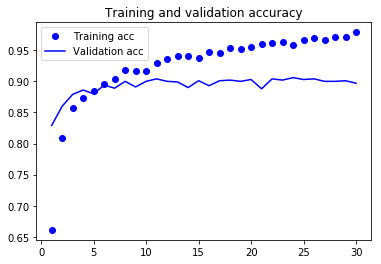

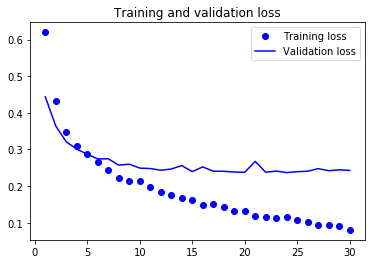

In [23]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Note: huge overfitting despite dropout; this because no data augmentation !!!